In [1]:
import torch
import argparse
import random
import numpy as np
import pandas as pd
from src.graph_func import graph_construction
from src.utils_func import mk_dir, adata_preprocess, load_ST_file, res_search_fixed_clus, plot_clustering
from src.training import conST_training

import anndata
from sklearn import metrics
import matplotlib.pyplot as plt
import scanpy as sc
import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/lytq/Spatial-Transcriptomics-Benchmark/utils')
from sdmbench import compute_ARI, compute_NMI, compute_CHAOS, compute_PAS, compute_ASW, compute_HOM, compute_COM

import time
import psutil
import tracemalloc

In [8]:
def evaluate_clustering(adata: sc.AnnData, df_meta, time_taken: float, memory_used: float, output_dir: str) -> dict:
    """Evaluate clustering using sdmbench"""
    gt_key = 'ground_truth'
    pred_key = 'refine'
    adata.obs['ground_truth'] = df_meta['fine_annot_type'].values
    adata = adata[~pd.isnull(adata.obs['ground_truth'])]
    
    results = {
        "ARI": compute_ARI(adata, gt_key, pred_key),
        "AMI": compute_NMI(adata, gt_key, pred_key),
        "Homogeneity": compute_HOM(adata, gt_key, pred_key),
        "Completeness": compute_COM(adata, gt_key, pred_key),
        "ASW": compute_ASW(adata, pred_key),
        "CHAOS": compute_CHAOS(adata, pred_key),
        "PAS": compute_PAS(adata, pred_key),
        "Time": time_taken,
        "Memory": memory_used
    }
    
    df_results = pd.DataFrame([results])
    df_results.to_csv(os.path.join(output_dir, "metrics.csv"), index=False)
    return results

In [3]:
def refine(sample_id, pred, dis, shape="hexagon"):
    refined_pred=[]
    pred=pd.DataFrame({"pred": pred}, index=sample_id)
    dis_df=pd.DataFrame(dis, index=sample_id, columns=sample_id)
    if shape=="hexagon":
        num_nbs=6 
    elif shape=="square":
        num_nbs=4
    else:
        print("Shape not recongized, shape='hexagon' for Visium data, 'square' for ST data.")
    for i in range(len(sample_id)):
        index=sample_id[i]
        dis_tmp=dis_df.loc[index, :].sort_values(ascending=False)
        nbs=dis_tmp[0:num_nbs+1]
        nbs_pred=pred.loc[nbs.index, "pred"]
        self_pred=pred.loc[index, "pred"]
        v_c=nbs_pred.value_counts()
        if (v_c.loc[self_pred]<num_nbs/2) and (np.max(v_c)>num_nbs/2):
            refined_pred.append(v_c.idxmax())
        else:           
            refined_pred.append(self_pred)
    return refined_pred

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--k', type=int, default=10, help='parameter k in spatial graph')
parser.add_argument('--knn_distanceType', type=str, default='euclidean',
                    help='graph distance type: euclidean/cosine/correlation')
parser.add_argument('--epochs', type=int, default=200, help='Number of epochs to train.')
parser.add_argument('--cell_feat_dim', type=int, default=300, help='Dim of PCA')
parser.add_argument('--feat_hidden1', type=int, default=100, help='Dim of DNN hidden 1-layer.')
parser.add_argument('--feat_hidden2', type=int, default=20, help='Dim of DNN hidden 2-layer.')
parser.add_argument('--gcn_hidden1', type=int, default=32, help='Dim of GCN hidden 1-layer.')
parser.add_argument('--gcn_hidden2', type=int, default=8, help='Dim of GCN hidden 2-layer.')
parser.add_argument('--p_drop', type=float, default=0.2, help='Dropout rate.')
parser.add_argument('--use_img', type=bool, default=False, help='Use histology images.')
parser.add_argument('--img_w', type=float, default=0.1, help='Weight of image features.')
parser.add_argument('--use_pretrained', type=bool, default=True, help='Use pretrained weights.')
parser.add_argument('--using_mask', type=bool, default=False, help='Using mask for multi-dataset.')
parser.add_argument('--feat_w', type=float, default=10, help='Weight of DNN loss.')
parser.add_argument('--gcn_w', type=float, default=0.1, help='Weight of GCN loss.')
parser.add_argument('--dec_kl_w', type=float, default=10, help='Weight of DEC loss.')
parser.add_argument('--gcn_lr', type=float, default=0.01, help='Initial GNN learning rate.')
parser.add_argument('--gcn_decay', type=float, default=0.01, help='Initial decay rate.')
parser.add_argument('--dec_cluster_n', type=int, default=10, help='DEC cluster number.')
parser.add_argument('--dec_interval', type=int, default=20, help='DEC interval nnumber.')
parser.add_argument('--dec_tol', type=float, default=0.00, help='DEC tol.')

parser.add_argument('--seed', type=int, default=0, help='random seed')
parser.add_argument('--beta', type=float, default=100, help='beta value for l2c')
parser.add_argument('--cont_l2l', type=float, default=0.3, help='Weight of local contrastive learning loss.')
parser.add_argument('--cont_l2c', type=float, default= 0.1, help='Weight of context contrastive learning loss.')
parser.add_argument('--cont_l2g', type=float, default= 0.1, help='Weight of global contrastive learning loss.')

parser.add_argument('--edge_drop_p1', type=float, default=0.1, help='drop rate of adjacent matrix of the first view')
parser.add_argument('--edge_drop_p2', type=float, default=0.1, help='drop rate of adjacent matrix of the second view')
parser.add_argument('--node_drop_p1', type=float, default=0.2, help='drop rate of node features of the first view')
parser.add_argument('--node_drop_p2', type=float, default=0.3, help='drop rate of node features of the second view')

# ______________ Eval clustering Setting ______________
parser.add_argument('--eval_resolution', type=int, default=1, help='Eval cluster number.')
parser.add_argument('--eval_graph_n', type=int, default=20, help='Eval graph kN tol.') 

params =  parser.parse_args(args=['--k', '20', '--knn_distanceType', 'euclidean', '--epochs', '200'])

np.random.seed(params.seed)
torch.manual_seed(params.seed)
torch.cuda.manual_seed(params.seed)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Using device: ' + device)
params.device = device

Using device: cuda:0


In [5]:
"""
path = './data/spatialLIBD/151673'
adata_h5 = load_ST_file(path, count_file='151673_filtered_feature_bc_matrix.h5')
adata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=params.cell_feat_dim)
graph_dict = graph_construction(adata_h5.obsm['spatial'], adata_h5.shape[0], params)
np.save('./input/adatax.npy', adata_X)
np.save('./input/graphdict.npy', graph_dict, allow_pickle = True)
"""

"\npath = './data/spatialLIBD/151673'\nadata_h5 = load_ST_file(path, count_file='151673_filtered_feature_bc_matrix.h5')\nadata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=params.cell_feat_dim)\ngraph_dict = graph_construction(adata_h5.obsm['spatial'], adata_h5.shape[0], params)\nnp.save('./input/adatax.npy', adata_X)\nnp.save('./input/graphdict.npy', graph_dict, allow_pickle = True)\n"

In [6]:
# set seed before every run
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_torch(params.seed)

In [7]:
data_name = 'V1_Human_Breast_Cancer_Block_A_Section_1'
save_root = '/home/lytq/Spatial-Transcriptomics-Benchmark/results2/BRCA1/conST'
data_root = '/home/lytq/Spatial-Transcriptomics-Benchmark/data/BRCA1'

params.save_path = mk_dir(save_root)

timee_start = time.time()
tracemalloc.start()

path = f'{data_root}/{data_name}'
adata_h5 = load_ST_file(path, count_file='filtered_feature_bc_matrix.h5')

# adata_X = np.load('/home/lytq/Spatial-Transcriptomics-Benchmark/conST/input/adatax.npy')
adata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=params.cell_feat_dim)

# graph_dict = np.load('/home/lytq/Spatial-Transcriptomics-Benchmark/conST/input/graphdict.npy',  allow_pickle = True).item()
graph_dict = graph_construction(adata_h5.obsm['spatial'], adata_h5.shape[0], params)

params.cell_num = adata_h5.shape[0]

n_clusters = 20
if params.use_img:
    img_transformed = np.load('./MAE-pytorch/extracted_feature.npy')
    img_transformed = (img_transformed - img_transformed.mean()) / img_transformed.std() * adata_X.std() + adata_X.mean()
    conST_net = conST_training(adata_X, graph_dict, params, n_clusters, img_transformed)
else:
    conST_net = conST_training(adata_X, graph_dict, params, n_clusters)


conST_net.pretraining()
conST_net.major_training()

conST_embedding = conST_net.get_embedding()

# clustering
adata_conST = anndata.AnnData(conST_embedding, obs=adata_h5.obs)
adata_conST.uns['spatial'] = adata_h5.uns['spatial']
adata_conST.obsm['spatial'] = adata_h5.obsm['spatial']

sc.pp.neighbors(adata_conST, n_neighbors=params.eval_graph_n)

eval_resolution = res_search_fixed_clus(adata_conST, n_clusters)
print(eval_resolution)
cluster_key = "conST_leiden"
sc.tl.leiden(adata_conST, key_added=cluster_key, resolution=eval_resolution)


df_meta = pd.read_csv(f'{data_root}/{data_name}/metadata.tsv', sep='\t')
df_meta['conST'] = adata_conST.obs[cluster_key].tolist()
# df_meta.to_csv(f'{params.save_path}/metadata.csv', index=False)

index = np.arange(start=0, stop=adata_X.shape[0]).tolist()
index = [str(x) for x in index]

dis = graph_dict['adj_norm'].to_dense().numpy() + np.eye(graph_dict['adj_norm'].shape[0])
refine = refine(sample_id = index, pred = adata_conST.obs['leiden'].tolist(), dis=dis)
adata_conST.obs['refine'] = refine

adata_conST.obs['layer_guess'] = df_meta['fine_annot_type'].values
sc.tl.umap(adata_conST)


time_taken = time.time() - timee_start
current, peak = tracemalloc.get_traced_memory()
memory_used = peak / (1024 ** 2)



adata: (3798, 36601)
===== Preprocessing Data 


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 203.5375retraining stage:  |####            | 60 / 200 | Left time: 0.02 mins| Loss: 210.5758
Major training stage:  |################| 200 / 200 | Loss: 3.3249


1.4699999999999998


KeyError: 'pred'

In [9]:
results = evaluate_clustering(adata_conST, df_meta, time_taken, memory_used, params.save_path)

In [11]:
adata_conST.obs

,leiden,conST_leiden,refine,layer_guess,ground_truth
0,17,17,17,Tumor_edge_5,Tumor_edge_5
1,0,0,0,IDC_4,IDC_4
2,2,2,2,Healthy_1,Healthy_1
3,2,2,2,IDC_3,IDC_3
4,0,0,0,IDC_4,IDC_4
...,...,...,...,...,...
3793,12,12,12,IDC_7,IDC_7
3794,0,0,0,IDC_4,IDC_4
3795,0,0,0,IDC_4,IDC_4
3796,4,4,1,Tumor_edge_2,Tumor_edge_2


In [12]:
# adata_conST.uns['refine_colors'] = adata_conST.uns['layer_guess_colors']
adata_conST.obs['refine_shift'] = (adata_conST.obs['refine'].astype(int) + 1).astype('category')

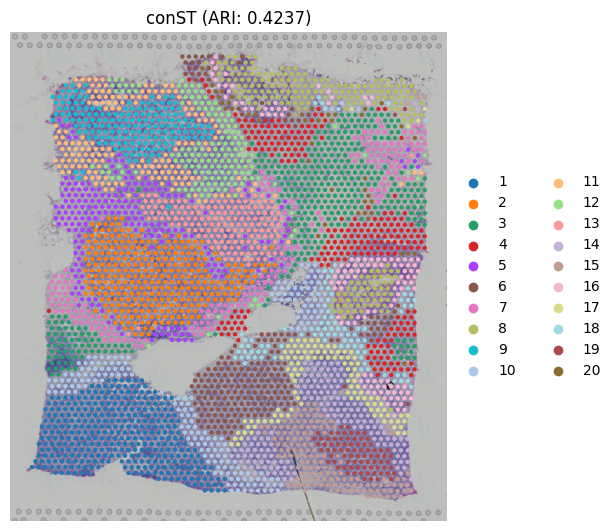

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.spatial(adata_conST, color='refine_shift', ax=ax, show=False)
ax.set_title(f'conST (ARI: {results["ARI"]:.4f})')
ax.axis('off')
plt.tight_layout()
plt.savefig(f'{params.save_path}/clustering.pdf', format='pdf', dpi=300, bbox_inches='tight')

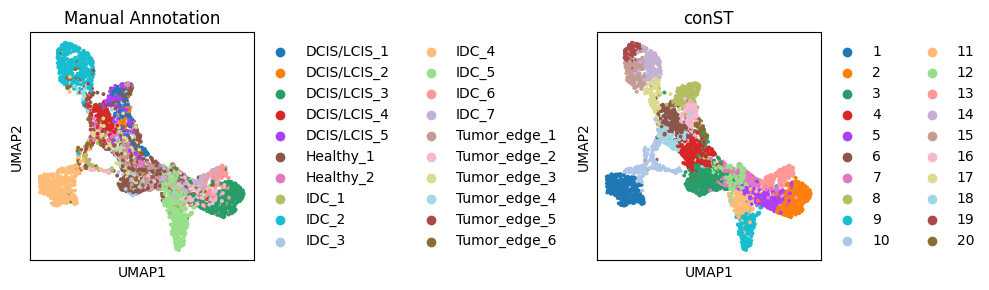

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
sc.pl.umap(adata_conST, color='ground_truth', ax=ax[0], show=False)
sc.pl.umap(adata_conST, color='refine_shift', ax=ax[1], show=False)
ax[0].set_title('Manual Annotation')
ax[1].set_title('conST')

plt.tight_layout()
plt.savefig(f'{params.save_path}/umap.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [19]:
adata_conST.obsm['conST'] = conST_embedding
low_dim_data = pd.DataFrame(adata_conST.obsm['conST'], index=adata_conST.obs.index)
low_dim_data.to_csv(f'{params.save_path}/low_dim_data.csv', index=False)
adata_conST.obs.to_csv(f'{params.save_path}/cell_metadata.csv')
umap_coords = adata_conST.obsm["X_umap"]
spot_ids = adata_conST.obs_names
umap_df = pd.DataFrame(umap_coords, columns=["UMAP1", "UMAP2"])
umap_df["spot_id"] = spot_ids
umap_df = umap_df[["spot_id", "UMAP1", "UMAP2"]]
umap_df.to_csv(f'{params.save_path}/spatial_umap_coords.csv', index=False)